# 0. Initialize

## 0.1. Import Libraries

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
#pd.set_option("display.max_columns", None)
from sklearn.model_selection import RepeatedKFold
from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from google.colab import drive
import seaborn as sns
sns.set()
from functools import reduce
drive.mount('/content/drive/')
!pip install catboost


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer


Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.1 MB/s eta 0:00:00


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Garanti/garanti-bbva-data-camp/'

## 0.2. DEFINE VARIABLES

In [ ]:
submission_df = pd.read_csv('{}submission.csv'.format(DATA_PATH))
languages_df = pd.read_csv('{}languages.csv'.format(DATA_PATH))
test_users_df = pd.read_csv('{}test_users.csv'.format(DATA_PATH))
skills_df = pd.read_csv('{}skills.csv'.format(DATA_PATH))
education_df = pd.read_csv('{}education.csv'.format(DATA_PATH))
train_users_df = pd.read_csv('{}train_users.csv'.format(DATA_PATH))
work_experiences_df = pd.read_csv('{}work_experiences.csv'.format(DATA_PATH), dtype={'start_year_month': str})

## 0.3. Print the submission, test and train set for observation

In [ ]:
submission_df

,user_id,moved_after_2019
0,17449,NaN
1,33967,NaN
2,2110,NaN
3,55082,NaN
4,37165,NaN
...,...,...
13250,32847,NaN
13251,20054,NaN
13252,7029,NaN
13253,56130,NaN


In [ ]:
test_users_df

,user_id,industry,location
0,17449,Research,Turkey
1,33967,Computer Software,"Istanbul, Istanbul, Turkey"
2,2110,Automotive,Turkey
3,55082,Internet,Turkey
4,37165,Electrical/Electronic Manufacturing,Turkey
...,...,...,...
13250,32847,Computer Software,Turkey
13251,20054,Hospital & Health Care,Turkey
13252,7029,Wireless,"Istanbul, Turkey"
13253,56130,Information Technology and Services,"Ankara, Turkey"


In [ ]:
train_users_df

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1
1,6950,Internet,"Istanbul, Istanbul, Turkey",0
2,4880,Online Media,Turkey,0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0
4,11005,Banking,"Istanbul, Turkey",0
...,...,...,...,...
53014,57247,Information Technology and Services,"Istanbul, Istanbul, Turkey",0
53015,37784,Telecommunications,"Istanbul, Turkey",0
53016,33229,Information Technology and Services,"Ankara, Turkey",0
53017,12165,Internet,"Istanbul, Turkey",1


In [ ]:
train_users_df['industry'].unique()

array(['Information Technology and Services', 'Internet', 'Online Media',
       'Telecommunications', 'Banking', 'Computer Software',
       'Mobile Games', 'Government Administration', 'Financial Services',
       'Electrical/Electronic Manufacturing', 'Wholesale',
       'Entertainment', 'Defense & Space', 'Computer & Network Security',
       'Semiconductors', 'Renewables & Environment', 'Food Production',
       'Logistics and Supply Chain', 'Program Development',
       'Leisure, Travel & Tourism', 'Real Estate',
       'Industrial Automation', 'Machinery', 'Publishing',
       'Health, Wellness and Fitness', 'Automotive', 'Consumer Goods',
       'Construction', 'Education Management', 'Aviation & Aerospace',
       'Food & Beverages', 'Computer Games', 'Retail',
       'Staffing and Recruiting', 'Computer Hardware', 'Oil & Energy',
       'Cosmetics', 'Photography', 'Mechanical or Industrial Engineering',
       'Wireless', 'Computer Networking', 'Airlines/Aviation',
       'Ma

<AxesSubplot:xlabel='moved_after_2019', ylabel='count'>

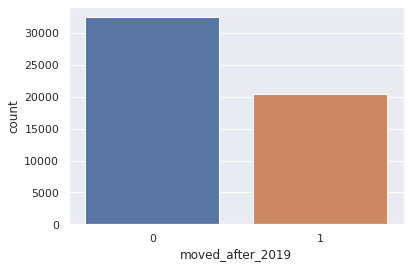

In [ ]:
sns.countplot(x='moved_after_2019', data=train_users_df)

In [ ]:
f= train_users_df[train_users_df['moved_after_2019'] == 1]['industry'].value_counts()
f.head(10)


Computer Software                      6544
Information Technology and Services    4666
Defense & Space                        1057
Telecommunications                      956
Internet                                755
Banking                                 580
Automotive                              446
Aviation & Aerospace                    381
Electrical/Electronic Manufacturing     360
Computer & Network Security             328
Name: industry, dtype: int64

In [ ]:
train_users_df['industry'].value_counts().head(10)


Computer Software                      17177
Information Technology and Services    11067
Telecommunications                      2912
Defense & Space                         2325
Banking                                 1634
Internet                                1531
Automotive                              1234
Electrical/Electronic Manufacturing      987
Computer & Network Security              850
Aviation & Aerospace                     824
Name: industry, dtype: int64

# 1. EXTRACT FEATURES



## 1.0. Extract Industry and Location data

## 1.0.1. Train Data

In [ ]:
#fill the nan value to avoid errors
train_users_df['location'] = train_users_df['location'].fillna('Turkey')
train_users_df['industry'] = train_users_df['industry'].fillna('Turkey')

In [ ]:
big_cities = ['Istanbul', 'İzmir','Kocaeli','Ankara', 'Izmir', 'İstanbul' ]

def check_city(x):

     if any(city in x for city in big_cities):
        return 1
     else:
        return 0

In [ ]:
train_users_df['isBigCity'] = train_users_df['location'].apply(check_city)


In [ ]:
it_list = ['Computer Software','Information Technology and Services','Computer & Network Security','Computer Games',
       'Mobile Games', 'Program Development','Industrial Automation','Internet','Computer Networking', 'Design','Machinery','Graphic Design',
        'Computer Hardware','Animation','Motion Pictures and Film',]

banking_list = ['Financial Services','Telecommunications','Banking','Human Resources','Investment Banking','Capital Markets','Public Relations and Communications',
                'Information Services','Executive Office','Public Policy','Accounting']


other_engineering = ['Mechanical or Industrial Engineering','Civil Engineering','Architecture & Planning','Semiconductors','Nanotechnology','Electrical/Electronic Manufacturing']

space_list = ['Defense & Space','Aviation & Aerospace','Airlines/Aviation']

ticaret_list = ['Food & Beverages','Broadcast Media','Media Production','Automotive','Retail','Furniture','Luxury Goods & Jewelry','Textiles',
             'Food Production','Hospitality','Consumer Goods','Consumer Services','International Trade and Development','Restaurants','Online Media',
             'Entertainment','Consumer Electronics','Leisure, Travel & Tourism','Paper & Forest Products','Sporting Goods','Import and Export','Civic & Social Organization',
             'Events Services','Railroad Manufacture','Supermarkets'
             ]

environment_list = ['Renewables & Environment', 'Oil & Energy','Plastics','Environmental Services',]

management_list = ['Education Management','Business Supplies and Equipment','Government Administration','Insurance','Investment Management',
                   'Nonprofit Organization Management','Logistics and Supply Chain','Accounting','Marketing and Advertising','Packaging and Containers',
                   'Management Consulting','Staffing and Recruiting','Wholesale','Market Research','International Affairs']

health_list = ['Hospital & Health Care','Medical Devices','Pharmaceuticals','Biotechnology','Chemicals','Veterinary','Medical Practice', 'Health, Wellness and Fitness','Mental Health Care',
               'Alternative Medicine',]

other_list = ['Electrical/Electronic Manufacturing', 'E-Learning','Higher Education','Fishery','Writing and Editing','Construction','Research',
              'Mining & Metals','Security and Investigations','Military','Government Relations','Gambling & Casinos','Translation and Localization','Outsourcing/Offshoring',
              'Printing','Cosmetics','Apparel & Fashion','Transportation/Trucking/Railroad','Maritime','Wireless', 'Glass, Ceramics & Concrete','Sports', 'Law Practice',
       'Publishing', 'Music', 'Commercial Real Estate', 'Public Safety','-1','Arts and Crafts', 'Building Materials','Tobacco', 'Photography','Primary/Secondary Education',
        'Performing Arts', 'Real Estate', 'Facilities Services','Legal Services', 'Recreational Facilities and Services','Shipbuilding', 'Fine Art','Legislative Office']



In [ ]:
def check_industry(x):

     if any(industry in x for industry in it_list):
        return 1
     elif any(industry in x for industry in banking_list):
         return 2
     elif any(industry in x for industry in space_list):
        return 3
     elif any(industry in x for industry in ticaret_list):
        return 4
    #  elif any(industry in x for industry in environment_list):
    #     return 5
    #  elif any(industry in x for industry in management_list):
    #     return 6
    #  elif any(industry in x for industry in health_list):
    #     return 7
     else:
       return 0


In [ ]:
train_users_df['industry_type'] = train_users_df['industry'].apply(check_industry)

In [ ]:
train_users_df

,user_id,industry,location,moved_after_2019,isBigCity,industry_type
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1,1,1
1,6950,Internet,"Istanbul, Istanbul, Turkey",0,1,1
2,4880,Online Media,Turkey,0,0,4
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0,1,2
4,11005,Banking,"Istanbul, Turkey",0,1,2
...,...,...,...,...,...,...
53014,57247,Information Technology and Services,"Istanbul, Istanbul, Turkey",0,1,1
53015,37784,Telecommunications,"Istanbul, Turkey",0,1,2
53016,33229,Information Technology and Services,"Ankara, Turkey",0,1,1
53017,12165,Internet,"Istanbul, Turkey",1,1,1


In [ ]:
train_users_df = train_users_df.drop(['industry', 'location'], axis = 1)

In [ ]:
train_users_df = pd.get_dummies(train_users_df, columns = ['industry_type'])
train_users_df

,user_id,moved_after_2019,isBigCity,industry_type_0,industry_type_1,industry_type_2,industry_type_3,industry_type_4
0,1301,1,1,0,1,0,0,0
1,6950,0,1,0,1,0,0,0
2,4880,0,0,0,0,0,0,1
3,26046,0,1,0,0,1,0,0
4,11005,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
53014,57247,0,1,0,1,0,0,0
53015,37784,0,1,0,0,1,0,0
53016,33229,0,1,0,1,0,0,0
53017,12165,1,1,0,1,0,0,0


## 1.0.2.Test Data

In [ ]:
test_users_df

,user_id,industry,location
0,17449,Research,Turkey
1,33967,Computer Software,"Istanbul, Istanbul, Turkey"
2,2110,Automotive,Turkey
3,55082,Internet,Turkey
4,37165,Electrical/Electronic Manufacturing,Turkey
...,...,...,...
13250,32847,Computer Software,Turkey
13251,20054,Hospital & Health Care,Turkey
13252,7029,Wireless,"Istanbul, Turkey"
13253,56130,Information Technology and Services,"Ankara, Turkey"


In [ ]:
test_users_df['location'] = test_users_df['location'].fillna('Turkey')
test_users_df['industry'] = test_users_df['industry'].fillna('Turkey')

In [ ]:
test_users_df['isBigCity'] = test_users_df['location'].apply(check_city)
test_users_df['industry_type'] = test_users_df['industry'].apply(check_industry)
test_users_df = test_users_df.drop(['industry', 'location'], axis = 1)
test_users_df = pd.get_dummies(test_users_df, columns = ['industry_type'])

In [ ]:
test_users_df.loc[test_users_df['user_id'] == 24525]

,user_id,isBigCity,industry_type_0,industry_type_1,industry_type_2,industry_type_3,industry_type_4
7669,24525,1,0,1,0,0,0


## 1.1. Language dataset feature extraction



In [ ]:
languages_df

,user_id,language,proficiency
0,8,İngilizce,full_professional
1,8,Türkçe,native_or_bilingual
2,8,Fransızca,elementary
3,10,ingilizce,NaN
4,11,Turkish,native_or_bilingual
...,...,...,...
76057,66271,English,NaN
76058,66272,English,professional_working
76059,66273,Türkçe,native_or_bilingual
76060,66273,İngilizce,professional_working


In [ ]:
languages_df['proficiency'].isna().sum()

10661

In [ ]:
languages_df[languages_df['language'].notnull() & languages_df['proficiency'].notnull()]

,user_id,language,proficiency
0,8,İngilizce,full_professional
1,8,Türkçe,native_or_bilingual
2,8,Fransızca,elementary
4,11,Turkish,native_or_bilingual
5,11,English,professional_working
...,...,...,...
76054,66262,English,full_professional
76058,66272,English,professional_working
76059,66273,Türkçe,native_or_bilingual
76060,66273,İngilizce,professional_working


### 1.1.1 Tune the proficiency

In [ ]:
languages_df.loc[languages_df['language'] == 'Fransızca, Orta (yaklaşık 1400-1600)']

,user_id,language,proficiency
11631,9919,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
32056,27479,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
32251,27629,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
32477,27790,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
37016,31201,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
37505,31571,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
37688,31720,"Fransızca, Orta (yaklaşık 1400-1600)",NaN
64603,56590,"Fransızca, Orta (yaklaşık 1400-1600)",NaN


In [ ]:
languages_df['proficiency'].unique()

array(['full_professional', 'native_or_bilingual', 'elementary', nan,
       'professional_working', 'limited_working'], dtype=object)

In [ ]:
#replace the categorical features to numerical ones to identify themn easily
languages_df['proficiency_num']= languages_df['proficiency'].replace(['native_or_bilingual','full_professional','professional_working','limited_working', 'elementary'],
                        [5,4,3,2,1])

In [ ]:
#see the content of the language to extract knowledge from them
languages_df['language'].unique()

array(['İngilizce', 'Türkçe', 'Fransızca', 'ingilizce', 'Turkish',
       'English', 'Kurdish', 'Almanca', 'Japanese', 'İspanyolca', 'Greek',
       'İngilizce, Orta (1100-1500)',
       'Almanca, Orta Yüksek (yaklaşık 1050-1500)', 'Türkmence',
       'ingilzce', 'Korece', 'İngilizce ', 'İngizce', 'Arabic', 'Rusça',
       'Romanca', 'Lehçe', 'Polish', 'Ingilizce',
       'İngilizce, Eski (yaklaşık 450-1100)', 'Japonca', 'Azerice',
       'German', 'Arapça', 'İnglizce', 'English (B2)', 'Francais',
       'Italiano', 'Farsça', 'Russian', 'Arapca ', 'Kürtçe',
       'İngilizce, Upper Intermediate', 'Arabish', 'İNGİLİZCE',
       'orta düzey İngilizce', 'Spanish', 'English, Middle (1100-1500)',
       'english', 'Portuguese', 'Germanic languages',
       'English (Upper-Intermediate)', 'French', 'Chinese', 'Sırpça',
       'Español', 'Bulgarian', 'Ermenice',
       'English-B2 Upper Intermediate', 'Turkish-Mother Language',
       'Français', 'İngilizce %30', 'Bulgarca',
       'İngilizce

In [ ]:
languages_df

,user_id,language,proficiency,proficiency_num
0,8,İngilizce,full_professional,4.0
1,8,Türkçe,native_or_bilingual,5.0
2,8,Fransızca,elementary,1.0
3,10,ingilizce,NaN,NaN
4,11,Turkish,native_or_bilingual,5.0
...,...,...,...,...
76057,66271,English,NaN,NaN
76058,66272,English,professional_working,3.0
76059,66273,Türkçe,native_or_bilingual,5.0
76060,66273,İngilizce,professional_working,3.0


In [ ]:
pd.isnull(languages_df.at[3, "proficiency"])

True

In [ ]:
level_1 = ['beginner', '%30','başlangıç', 'a1','a2', 'basic', 'düşük','temel']
level_2 = ['orta',  'b2', 'upper', 'İyi', 'b1', 'Intermediate','YDS : 93,75','excellent']
level_3 = [ 'advanced', 'c1','ileri']
level_4 = ['upper', 'advanced','Professional','IELTS 7']
level_5 = [ 'mother', 'native']

In [ ]:
##tune the nan valued proficiencies by using the information from language column
for i in languages_df.index[0:]:

    if (pd.isnull(languages_df.at[i, "proficiency_num"])):

        if any(level.lower() in languages_df.at[i, "language"].lower() for level in level_1) :
            languages_df.at[i, "proficiency_num"] = 1

        elif any(level.lower() in languages_df.at[i, "language"].lower() for level in level_2) :
            languages_df.at[i, "proficiency_num"] = 2
        elif any(level.lower() in languages_df.at[i, "language"].lower() for level in level_3) :
            languages_df.at[i, "proficiency_num"] = 3
        elif any(level.lower() in languages_df.at[i, "language"].lower() for level in level_4) :
            languages_df.at[i, "proficiency_num"] = 4
        elif any(level.lower() in languages_df.at[i, "language"].lower() for level in level_5) :
            languages_df.at[i, "proficiency_num"] = 5
        # else:
        #   languages_df.at[i, "proficiency_num"] = 1

In [ ]:
##drop the nan values
languages_df = languages_df[languages_df['language'].notnull() & languages_df['proficiency'].notnull()]

### 1.1.2 Tune the languages

In [ ]:
turkish_list = ['Türkçe','Turkish','Türkish','Türkisch','Turkçe','Türk','Turkce','TÜRKÇE','Turkısh','Türke','türkçe','Tükçe','turk','türkisch']
english_list = ['İngilizce','ingilizce','English','ingilzce', 'İngizce','İnglizce','İNGİLİZCE','Englisch','INGILIZCE','İnglilizce','ENGLISH','İngilzce','Engilish','İngilize','Ingles', 'engish', 'ing',
                'İngiliz','İng','İngizice']
german_list = ['Almanca','German','Deutsch','Germany','Gerrman','deutch']
spanish_list = ['İspanyolca','Spanish','Español','ISPANYOLCA','ispanyolca','Spani','Espańol']
italian_list = ['Italiano','italian','İtalyanca','Italian','italyanca','Italien','İtalian' ]
french_list = ['Fransızca','Francais','French','Français','France','Fransa','Fransız','Fransizca']
arabic_list = ['Arabic','Arapça','Arapca','Arabish','arapça','arapca']
russian_list = ['Rusça','Russian','Rusca','Russe','rusca','Russain']
asian_list = ['Japanese','Korece','Japonca','Chinese','Çince','Korean','Japanes','Çinçe' ]



In [ ]:
#see the content of the language to extract knowledge from them
languages_df['language'].unique()

array(['İngilizce', 'Türkçe', 'Fransızca', 'Turkish', 'English',
       'Kurdish', 'Almanca', 'Japanese', 'İspanyolca', 'Greek',
       'Türkmence', 'ingilzce', 'ingilizce', 'Korece', 'İngizce',
       'Arabic', 'Rusça', 'Romanca', 'Lehçe', 'Polish',
       'İngilizce, Eski (yaklaşık 450-1100)', 'Japonca', 'Azerice',
       'German', 'Arapça', 'İnglizce', 'English (B2)', 'Francais',
       'Italiano', 'Farsça', 'Russian', 'İngilizce ', 'Arapca ',
       'İngilizce, Orta (1100-1500)', 'İngilizce, Upper Intermediate',
       'Arabish', 'Kürtçe', 'english', 'Portuguese', 'Spanish',
       'Germanic languages', 'English, Middle (1100-1500)', 'French',
       'Chinese', 'Sırpça', 'Español', 'Bulgarian', 'Ermenice',
       'Français', 'Bulgarca', 'İngilizce, İyi(1100-1500)', 'Armenian',
       'Romanian', 'Azerbaijani', 'Ukrainian', 'İtalyanca', 'Çekçe ',
       'Boşnakça', 'Çince', 'Italian', 'Türkish', 'Özbekçe', 'Turkmence',
       'İNGİLİZCE', 'Lehçe Polish', 'Deutsch', 'Rusca',
       '

In [ ]:
languages_df['language_new'] = languages_df['language']

<ipython-input-38-b2f9970302ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  languages_df['language_new'] = languages_df['language']


In [ ]:
for i in languages_df.index[0:]:

        if any(lang.lower() in languages_df.at[i, "language"].lower() for lang in turkish_list) :
            languages_df.at[i, "language_new"] = 'Turkish'

        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in english_list) :
            languages_df.at[i, "language_new"] = 'English_l'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in german_list) :
            languages_df.at[i, "language_new"] = 'German'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in spanish_list) :
            languages_df.at[i, "language_new"] = 'Spanish'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in italian_list) :
            languages_df.at[i, "language_new"] = 'Italian'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in french_list) :
            languages_df.at[i, "language_new"] = 'French'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in asian_list) :
            languages_df.at[i, "language_new"] = 'Asian'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in russian_list) :
            languages_df.at[i, "language_new"] = 'Russian'
        elif any(lang.lower() in languages_df.at[i, "language"].lower() for lang in arabic_list) :
            languages_df.at[i, "language_new"] = 'Arabic'
        else :
          languages_df.at[i, "language_new"] = 'Other'

In [ ]:
languages_df['language_new'].unique()

array(['English_l', 'Turkish', 'French', 'Other', 'German', 'Asian',
       'Spanish', 'Arabic', 'Russian', 'Italian'], dtype=object)

In [ ]:
languages_df

,user_id,language,proficiency,proficiency_num,language_new
0,8,İngilizce,full_professional,4.0,English_l
1,8,Türkçe,native_or_bilingual,5.0,Turkish
2,8,Fransızca,elementary,1.0,French
4,11,Turkish,native_or_bilingual,5.0,Turkish
5,11,English,professional_working,3.0,English_l
...,...,...,...,...,...
76054,66262,English,full_professional,4.0,English_l
76058,66272,English,professional_working,3.0,English_l
76059,66273,Türkçe,native_or_bilingual,5.0,Turkish
76060,66273,İngilizce,professional_working,3.0,English_l


In [ ]:
df_language_test = pd.pivot_table(languages_df, values = 'proficiency_num', index='user_id', columns = 'language_new').reset_index().rename_axis(None, axis=1)
df_language_test = df_language_test.fillna(0)
df_language_test = df_language_test.astype(int)
df_language_test.head()

,user_id,Arabic,Asian,English_l,French,German,Italian,Other,Russian,Spanish,Turkish
0,8,0,0,4,1,0,0,0,0,0,5
1,11,0,0,3,0,0,0,5,0,0,5
2,12,0,0,3,0,0,0,0,0,0,5
3,13,0,0,4,0,2,0,0,0,0,0
4,14,0,0,3,0,0,0,0,0,0,5


In [ ]:
# def adjust_english(x):

#   if(x>1):
#     return 1
#   else:
#     return x

# df_language_test['English'] = df_language_test['English'].apply(adjust_english)

## 1.2 Education dataset feature extraction




In [ ]:
education_df

,user_id,school_name,degree,fields_of_study,start_year_month,end_year_month
0,0,Anadolu Üniversitesi,NaN,NaN,NaN,NaN
1,0,Adıyaman Üniversitesi,NaN,NaN,NaN,NaN
2,0,Fırat Üniversitesi,NaN,NaN,NaN,NaN
3,1,Fırat Üniversitesi,Yüksek Lisans,Yazılım Mühendisliği,NaN,NaN
4,1,Fırat Üniversitesi,Lisans,Yazılım Mühendisliği,NaN,NaN
...,...,...,...,...,...,...
142570,66272,Halmstad University,NaN,Computer Science,NaN,NaN
142571,66272,Bogazici University,NaN,Chemistry,NaN,NaN
142572,66273,Istanbul Technical University,Bachelor's degree,Electronic and Communication Engineering,NaN,NaN
142573,66273,Bogazici University,Master's degree,Electrical and Electronics Engineering,201509.0,NaN


In [ ]:
education_df['degree'] = education_df['degree'].fillna("yok")

In [ ]:
work_experiences_df.loc[work_experiences_df['user_id'] == 2213]

,user_id,company_id,location,start_year_month
54163,2213,3117,"Istanbul, Turkey",201909
167397,2213,3118,NaN,201810


In [ ]:
education_df.isna().sum()

user_id                  0
school_name              0
degree                   0
fields_of_study      19838
start_year_month    134373
end_year_month      134985
dtype: int64

### 1.2.1 Tune Education Value

In [ ]:
education_df.loc[education_df['user_id'] == 22497]

,user_id,school_name,degree,fields_of_study,start_year_month,end_year_month
48668,22497,Erciyes Üniversitesi,Lisans Derecesi,Endüstri Mühendisliği,NaN,NaN


In [ ]:
education_list=['lise','high school', 'okul', 'kolej', 'college','LİSE','Highschool', 'primary','Eğitim','İlköğretim','ilköğretim','Kurum','elementary','A.T.L','E.M.L','T.M.L','A.L','EML','AML',
                'anatolian','HİGH SCHOOL','ATL', 'ATBL','ATML','Dershane','Oguzkaan','Kodluyoruz','M.E.B','Ilkogretim','BAL','IFL']

In [ ]:
def check_education(x):

     if any(city.lower() in x.lower() for city in education_list):
        return 0
     else:
        return 1

In [ ]:
education_df['education_value'] = education_df['school_name'].apply(check_education)
education_df = education_df[education_df.education_value != 0]

In [ ]:
# aggregation_functions = {'school_name': 'last','degree': 'last','fields_of_study': 'last', 'education_value': 'sum','cs_count': 'sum' }
# education_new = education_df.groupby(education_df['user_id'],as_index=False).aggregate(aggregation_functions)

In [ ]:
# def normalize_education(x):
#   if (x >5):
#     return 5
#   else:
#     return x

# education_new['education_value'] = education_new['education_value'].apply(normalize_education)

In [ ]:
education_df

,user_id,school_name,degree,fields_of_study,start_year_month,end_year_month,education_value
0,0,Anadolu Üniversitesi,yok,NaN,NaN,NaN,1
1,0,Adıyaman Üniversitesi,yok,NaN,NaN,NaN,1
2,0,Fırat Üniversitesi,yok,NaN,NaN,NaN,1
3,1,Fırat Üniversitesi,Yüksek Lisans,Yazılım Mühendisliği,NaN,NaN,1
4,1,Fırat Üniversitesi,Lisans,Yazılım Mühendisliği,NaN,NaN,1
...,...,...,...,...,...,...,...
142569,66272,Yildiz Technical University,Bachelor's degree,Computer Engineering,NaN,NaN,1
142570,66272,Halmstad University,yok,Computer Science,NaN,NaN,1
142571,66272,Bogazici University,yok,Chemistry,NaN,NaN,1
142572,66273,Istanbul Technical University,Bachelor's degree,Electronic and Communication Engineering,NaN,NaN,1


In [ ]:
# education_new = pd.get_dummies(education_new, columns = ['education_value'])

In [ ]:
education_df.dtypes

user_id               int64
school_name          object
degree               object
fields_of_study      object
start_year_month    float64
end_year_month      float64
education_value       int64
dtype: object

### 1.2.4 Tune Education degree

In [ ]:
license_list = ['lisan','Licence','License','Bachelor','lİSANS','mühendis','B.S','Engineer','Fakulty','Associate','Licentiate','Undergrad',
                'Lisance','Licance','2.','2,','3,','Major','3.','Bacheor','BS','Baccalaureat','Junior','B. Sc', 'senior','Bc.',
                'B. S.','Bechalor','B Sc','M Sc','B.A','Baccalauréat','undergred','Bacheleer','4.Sınıf','Becholar','not graduated','B.C']

master_list = ['Yüksek','Master','M.S','Postgraduate','MSc','M.A','Post Graduate','MBA','M. Sc','MS','M. S.','Mater','Posgraduate', 'graduated']

phd_list = ['PhD','Doctor','Ph. D.','PH.D']

In [ ]:
def tune_degree(x):

  y=0

  if any(city.lower() in x.lower() for city in license_list):
      y = 1
  if any(city.lower() in x.lower() for city in master_list):
      y = 2
  if any(city.lower() in x.lower() for city in phd_list):
      y = 3
  return y




In [ ]:
education_df['new_degree'] = education_df['degree'].apply(tune_degree)

<ipython-input-59-fc799a6cb5cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_df['new_degree'] = education_df['degree'].apply(tune_degree)


In [ ]:
lines1 = education_df[education_df.new_degree == -1]['degree'].unique()

with open('degree.txt', 'w') as f:
    for line in lines1:
        f.write(f"{line}\n")

In [ ]:
'LİSANS'.lower() in 'LİSANS'.lower()

True

In [ ]:
education_df = pd.get_dummies(education_df, prefix=['Degree_Level'], columns=['new_degree'])

In [ ]:
education_df = education_df.drop(['Degree_Level_0'], axis=1)

In [ ]:
education_df

,user_id,school_name,degree,fields_of_study,start_year_month,end_year_month,education_value,Degree_Level_1,Degree_Level_2,Degree_Level_3
0,0,Anadolu Üniversitesi,yok,NaN,NaN,NaN,1,0,0,0
1,0,Adıyaman Üniversitesi,yok,NaN,NaN,NaN,1,0,0,0
2,0,Fırat Üniversitesi,yok,NaN,NaN,NaN,1,0,0,0
3,1,Fırat Üniversitesi,Yüksek Lisans,Yazılım Mühendisliği,NaN,NaN,1,0,1,0
4,1,Fırat Üniversitesi,Lisans,Yazılım Mühendisliği,NaN,NaN,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
142569,66272,Yildiz Technical University,Bachelor's degree,Computer Engineering,NaN,NaN,1,1,0,0
142570,66272,Halmstad University,yok,Computer Science,NaN,NaN,1,0,0,0
142571,66272,Bogazici University,yok,Chemistry,NaN,NaN,1,0,0,0
142572,66273,Istanbul Technical University,Bachelor's degree,Electronic and Communication Engineering,NaN,NaN,1,1,0,0


### 1.2.2 Tune School Name

In [ ]:
top_universities = ['Bogazici','Bosphorus','Bogaziçi', 'Boğaziçi', 'Bilkent', 'Sabanci', 'Sabancı','Koç Uni', 'Koç Üni', 'Orta Dogu Tek', 'Orta Doğu Tek', 'Ortadoğu Tek', 'OrtaDogu Tek',
                    'Middle East Tec','ODTÜ','METU', 'odtu','Koc Uni','Çankaya','Hacettepe','İstanbul Teknik','Istanbul Technical University','ITU','Istanbul Teknik','Ozyegin','Yildiz','Yıldız','Kocaeli','Gebze Teknik',
                    'Gebze Technical University','Oxford','Kaliforniya','california','Harvard','Stanford','Cambridge','Massachusetts','Princeton','Kaliforniya','Berkeley','Yale','Chicago','ETH','Londra','Toronto']

In [ ]:
turkish_universities = ['Ü', 'Ü', 'ü','ü', 'ı','İ','İ','ç','Ç', 'ğ','Ğ','ş','ö','Ö', 'Fırat','Firat','Kocaeli','Hasan', 'Bogazici','Bilkent','Bilge','Karabuk','Aksaray', 'Harran', 'Marmara', 'Amasya',
                        'Giresun','Anadolu', 'Istanbul', 'Dicle', 'Inonu', 'Gaziantep','Bahcesehir', 'Gazi', 'Malatya','Celal','mersin', 'Selcuk', 'Sakarya','Adnan',
                        'Mimar','Mustafa','Yildiz','Yunus','Siirt','Erzincan','Okan','Mehmet','Bilecik','Aleppo', 'Udacity','Sabanci', 'Bitlis','Abdurrahman','turkish','Konya',
                        'Erciyes','Dumlupinar', 'Frat','BILISIM', 'Bilgi', 'FIRAT', 'Cukurova','Zeytinburnu', 'Bartin', 'Yalova', 'Turkish', 'Ege', 'Beyken', 'Ahmet', 'Duzce',
                        'Akif','Maltepe','Middle East','Bosphorus','Bilkent','OrtaDogu','Gebze','Dokuz','Eylul', 'ilkent', 'Kirklareli','Izmir','Batikent','TOBB','Ankara','Erzurum','Egitim','Hacettepe',
                        'Ziraat','Hisar','Bursa','Turk','Antalya','Nazilli','ATILIM','KONYA','Girne','selcuk','Tevfik','istanbul','Nevzat','Cyprus', 'Trakya','Sisli','Sinop','Antakya','Hacettepe','Samsun','TED',
                        'Kahramanmaras','Ataturk', 'Uludag','Fatih','Karadeniz','Abant','Alper','Azerbaijan','Islamic','Black Sea','Kastamonu','Yeditepe','Pamukkale','Kavrakoglu','Suleyman','Akademi',
                        'Mujdat','Fatih','Kars','Eskisehir','Anatolia','Barbaros','Akhmet','Tuzla','Koc Uni','Trabzon','Tuskish','Kabul','Sri Lankan','Pakistan','Ghulam','Atilim','METU']

In [ ]:
'İ' in 'İstanbul'

True

In [ ]:
def check_school(x):

     if any(city in x for city in turkish_universities):
        return 0
     else:
        return 1

In [ ]:
def check_top(x):

     if any(city in x for city in top_universities):
        return 1
     else:
        return 0

In [ ]:
education_df['studied_abroad'] = education_df['school_name'].apply(check_school)
education_df['studied_top'] = education_df['school_name'].apply(check_top)

In [ ]:
lines1 = education_df[education_df.studied_abroad != 0]['school_name'].unique()
with open('university_names.txt', 'w') as f:
    for line in lines1:
        f.write(f"{line}\n")

### 1.2.3 Tune Fields

In [ ]:
education_df.tail(15)

,user_id,school_name,degree,fields_of_study,start_year_month,end_year_month,education_value,Degree_Level_1,Degree_Level_2,Degree_Level_3,studied_abroad,studied_top
142559,66269,Boğaziçi Üniversitesi,Master of Business Administration,Business Administration,NaN,NaN,1,0,1,0,0,1
142560,66269,Boğaziçi Üniversitesi,Bachelor of Science,Computer Engineering,NaN,NaN,1,1,0,0,0,1
142561,66269,OML,yok,NaN,NaN,NaN,1,0,0,0,1,0
142562,66270,Boğaziçi Üniversitesi,Master of Science - MS,Physics,NaN,NaN,1,0,1,0,0,1
142563,66270,Massachusetts Institute of Technology,MicroMaster-edX,"Data, Economics, and Development Policy",NaN,NaN,1,0,1,0,1,1
142564,66270,İstanbul Üniversitesi,Lisans Derecesi,Matematik,NaN,NaN,1,1,0,0,0,0
142565,66270,İstanbul Üniversitesi,Lisans Derecesi,Fizik,NaN,NaN,1,1,0,0,0,0
142566,66271,Boğaziçi Üniversitesi / Bogazici University,M.S,Science Education,NaN,NaN,1,0,1,0,0,1
142567,66271,Boğaziçi Üniversitesi / Bogazici University,B.S,Computer Education and Educational Techn.,NaN,NaN,1,1,0,0,0,1
142568,66271,Marmara University,Ph.D.,Informatics,NaN,NaN,1,0,0,1,0,0


In [ ]:
education_df["fields_of_study"].isna().sum()

8172

In [ ]:
education_df['fields_of_study'] = education_df['fields_of_study'].fillna("yok")

In [ ]:
lines = education_df.fields_of_study.unique()
lines.sort()
with open('fields.txt', 'w') as f:
    for line in lines:
        f.write(f"{line}\n")

In [ ]:
cs_field = ['Programming', 'Comput', 'Bigdata', 'Programmer', 'Compter', 'Electrical','Electronic','Elektronik','Data','Artificial',
            'Bilgisa','Informatics',  'Information ','Yapay Zeka','Veri','Network', 'Linux', 'iOS','Developer', 'Cisco', 'Communication',
            'Mekatronik', 'Mechatronic','Software', 'otomasyon', 'Automation', 'Yazılım','programlama','Kodlama','Electonics','Mechatronics',
            'Python','Bilişim','Java','yazilim','siber', 'Mathemetic','matematik', 'Cyber', 'SQL','Ağ','coding','web', 'COMPUT','.NET', 'Framework',
            'c#','Animation','Animasyon','3D Modelling','BİLİŞİM','Bilişim','ALGORITHM','Yazilim','AWS','cloud','Information','Android', 'Statistic','cryptography',
            'react','rest','Terraform','Visual Studio']

bank_field = ['Banking','BUSINESS' ,'Business','Management','Yönetim','Accounting','Economic','işletme']

space_list = ['Aeronautic','Aerospace','Aviation','Aircraft','Airframe','Astronaut','Avionic']

In [ ]:
'ALGORITHM'.lower() in 'Algorithm/Software Development for Experimental Physics'.lower()

True

In [ ]:
def check_cs(x):

  if any(city in x for city in cs_field):
        return 1
  else:
    return 0

def check_bank(x):

  if any(city in x for city in bank_field):
        return 1
  else:
    return 0

def check_space(x):

  if any(city in x for city in space_list):
        return 1
  else:
    return 0

In [ ]:
testarr = education_df['fields_of_study'].unique()
len(testarr)

9952

In [ ]:
education_df['cs_field'] = education_df['fields_of_study'].apply(check_cs)
education_df['bank_field'] = education_df['fields_of_study'].apply(check_bank)
# education_df['space_field'] = education_df['fields_of_study'].apply(check_space)

In [ ]:
aggregation_functions = {'cs_field': 'sum','bank_field': 'sum','studied_abroad':'sum','studied_top':'sum','Degree_Level_1': 'sum','Degree_Level_2': 'sum','Degree_Level_3': 'sum','education_value': 'sum'  }
education_new = education_df.groupby(education_df['user_id'],as_index=False).aggregate(aggregation_functions)

In [ ]:
def tune_values(x):

  if(x >1):
    return 1
  else:
    return x

In [ ]:
education_new

,user_id,cs_field,bank_field,studied_abroad,studied_top,Degree_Level_1,Degree_Level_2,Degree_Level_3,education_value
0,0,0,0,0,0,0,0,0,3
1,1,2,0,0,0,1,1,0,2
2,2,1,0,0,0,0,0,0,1
3,3,1,0,0,0,1,0,0,1
4,4,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
66237,66269,1,1,1,2,1,1,0,3
66238,66270,1,1,1,2,2,2,0,4
66239,66271,2,0,0,2,1,1,1,3
66240,66272,2,0,1,2,1,0,0,3


In [ ]:
# education_df['cs_field'] = education_df['cs_field'].apply(tune_values)
# education_df['bank_field'] = education_df['bank_field'].apply(tune_values)
education_df['studied_abroad'] = education_df['studied_abroad'].apply(tune_values)
# education_df['studied_top'] = education_df['studied_top'].apply(tune_values)
# education_df['space_field'] = education_df['space_field'].apply(tune_values)
education_new['Degree_Level_1'] = education_new['Degree_Level_1'].apply(tune_values)
education_new['Degree_Level_2'] = education_new['Degree_Level_2'].apply(tune_values)
education_new['Degree_Level_3'] = education_new['Degree_Level_3'].apply(tune_values)

In [ ]:
education_new

,user_id,cs_field,bank_field,studied_abroad,studied_top,Degree_Level_1,Degree_Level_2,Degree_Level_3,education_value
0,0,0,0,0,0,0,0,0,3
1,1,2,0,0,0,1,1,0,2
2,2,1,0,0,0,0,0,0,1
3,3,1,0,0,0,1,0,0,1
4,4,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
66237,66269,1,1,1,2,1,1,0,3
66238,66270,1,1,1,2,1,1,0,4
66239,66271,2,0,0,2,1,1,1,3
66240,66272,2,0,1,2,1,0,0,3


## 1.3 Working Experience dataset feature extraction



In [ ]:
##convert given date to actualt python date format
work_experiences_df['start_year_month'] = pd.to_datetime(work_experiences_df['start_year_month'], format='%Y%m')
work_experiences_df = work_experiences_df.sort_values(by=['user_id', 'start_year_month'])

In [ ]:
work_experiences_df.loc[work_experiences_df['user_id'] == 1034]

,user_id,company_id,location,start_year_month


In [ ]:
df_work_experiences_test = work_experiences_df.copy()

In [ ]:
#dropping the rows that contains  a job experience after 2019-01-01
cond1 = df_work_experiences_test.start_year_month < pd.Timestamp(2019,1,1)
test = df_work_experiences_test.loc[cond1,  ]

#counting the jobs of the user
test['job_count'] = test.groupby('user_id')['user_id'].transform('count')


<ipython-input-89-725c1447bfcd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['job_count'] = test.groupby('user_id')['user_id'].transform('count')


In [ ]:
test['days_worked'] = pd.Timestamp(2019,1,1) - test['start_year_month']
test["first_job_date"] = test["start_year_month"]

<ipython-input-90-2ea0f4f38643>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['days_worked'] = pd.Timestamp(2019,1,1) - test['start_year_month']
<ipython-input-90-2ea0f4f38643>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["first_job_date"] = test["start_year_month"]


In [ ]:

test['2018_exp'] = test['start_year_month'] > pd.Timestamp(2017,12,1)
test['2017_exp'] = (pd.Timestamp(2016,12,1) < test['start_year_month']) & (test['start_year_month'] < pd.Timestamp(2018,1,1))
test['2016_exp'] = (pd.Timestamp(2015,12,1) < test['start_year_month']) & (test['start_year_month'] < pd.Timestamp(2017,1,1) )

<ipython-input-91-ea47df5c62b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['2018_exp'] = test['start_year_month'] > pd.Timestamp(2017,12,1)
<ipython-input-91-ea47df5c62b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['2017_exp'] = (pd.Timestamp(2016,12,1) < test['start_year_month']) & (test['start_year_month'] < pd.Timestamp(2018,1,1))
<ipython-input-91-ea47df5c62b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [ ]:
test

,user_id,company_id,location,start_year_month,job_count,days_worked,first_job_date,2018_exp,2017_exp,2016_exp
147720,0,0,Serbest Çalışmalar,2005-09-01,2,4870 days,2005-09-01,False,False,False
174454,0,0,Visual Studio Asp.Net Developer,2005-09-01,2,4870 days,2005-09-01,False,False,False
760,2,9,"Elazig, Turkey",2016-12-01,3,761 days,2016-12-01,False,False,True
19762,2,7,"Elazig, Turkey",2017-06-01,3,579 days,2017-06-01,False,True,False
180157,2,10,"Mersin, Turkey",2018-06-01,3,214 days,2018-06-01,True,False,False
...,...,...,...,...,...,...,...,...,...,...
181958,66273,1900,NaN,2016-01-01,8,1096 days,2016-01-01,False,False,True
178765,66273,2696,NaN,2016-12-01,8,761 days,2016-12-01,False,False,True
24178,66273,1509,NaN,2017-08-01,8,518 days,2017-08-01,False,True,False
92682,66273,2412,NaN,2018-09-01,8,122 days,2018-09-01,True,False,False


### 1.3.1 New tuning

In [ ]:
work_new = test.copy()

In [ ]:
work_new['date_diff'] = work_new.groupby('user_id')['start_year_month'].diff()


In [ ]:
work_new

,user_id,company_id,location,start_year_month,job_count,days_worked,first_job_date,2018_exp,2017_exp,2016_exp,date_diff
147720,0,0,Serbest Çalışmalar,2005-09-01,2,4870 days,2005-09-01,False,False,False,NaT
174454,0,0,Visual Studio Asp.Net Developer,2005-09-01,2,4870 days,2005-09-01,False,False,False,0 days
760,2,9,"Elazig, Turkey",2016-12-01,3,761 days,2016-12-01,False,False,True,NaT
19762,2,7,"Elazig, Turkey",2017-06-01,3,579 days,2017-06-01,False,True,False,182 days
180157,2,10,"Mersin, Turkey",2018-06-01,3,214 days,2018-06-01,True,False,False,365 days
...,...,...,...,...,...,...,...,...,...,...,...
181958,66273,1900,NaN,2016-01-01,8,1096 days,2016-01-01,False,False,True,0 days
178765,66273,2696,NaN,2016-12-01,8,761 days,2016-12-01,False,False,True,335 days
24178,66273,1509,NaN,2017-08-01,8,518 days,2017-08-01,False,True,False,243 days
92682,66273,2412,NaN,2018-09-01,8,122 days,2018-09-01,True,False,False,396 days


In [ ]:
aggregation_functions = {'first_job_date':"first", 'start_year_month':"last", 'days_worked': 'first', 'job_count': 'last','2018_exp': 'sum','2017_exp': 'sum','2016_exp': 'sum', 'date_diff': 'sum'}
work_new = work_new.groupby(work_new['user_id'],as_index=False).aggregate(aggregation_functions)
work_new.rename(columns = {'start_year_month':'last_job_date'}, inplace = True)
work_new



,user_id,first_job_date,last_job_date,days_worked,job_count,2018_exp,2017_exp,2016_exp,date_diff
0,0,2005-09-01,2005-09-01,4870 days,2,0,0,0,0 days
1,2,2016-12-01,2018-06-01,761 days,3,1,1,1,547 days
2,5,2017-06-01,2017-06-01,579 days,1,0,1,0,0 days
3,7,2016-07-01,2018-12-01,914 days,4,1,2,1,883 days
4,10,2013-08-01,2018-05-01,1979 days,3,2,0,0,1734 days
...,...,...,...,...,...,...,...,...,...
52997,66269,2004-04-01,2018-12-01,5388 days,5,1,0,0,5357 days
52998,66270,2014-11-01,2018-12-01,1522 days,2,1,0,0,1491 days
52999,66271,2001-11-01,2016-11-01,6270 days,9,0,0,1,5479 days
53000,66272,2012-07-01,2018-12-01,2375 days,5,2,0,0,2344 days


In [ ]:
work_new['days_worked']=work_new['days_worked'].dt.days
work_new['date_diff']=work_new['date_diff'].dt.days
work_new['avg_day_spent_per_job'] = work_new['date_diff'].div(work_new['job_count']-1).replace(np.inf, 0)
work_new = work_new.fillna(0)

In [ ]:
work_new

,user_id,first_job_date,last_job_date,days_worked,job_count,2018_exp,2017_exp,2016_exp,date_diff,avg_day_spent_per_job
0,0,2005-09-01,2005-09-01,4870,2,0,0,0,0,0.000000
1,2,2016-12-01,2018-06-01,761,3,1,1,1,547,273.500000
2,5,2017-06-01,2017-06-01,579,1,0,1,0,0,0.000000
3,7,2016-07-01,2018-12-01,914,4,1,2,1,883,294.333333
4,10,2013-08-01,2018-05-01,1979,3,2,0,0,1734,867.000000
...,...,...,...,...,...,...,...,...,...,...
52997,66269,2004-04-01,2018-12-01,5388,5,1,0,0,5357,1339.250000
52998,66270,2014-11-01,2018-12-01,1522,2,1,0,0,1491,1491.000000
52999,66271,2001-11-01,2016-11-01,6270,9,0,0,1,5479,684.875000
53000,66272,2012-07-01,2018-12-01,2375,5,2,0,0,2344,586.000000


In [ ]:
##find the remaining days until 2020
work_new['days_remaining'] = pd.Timestamp(2020,1,1) - work_new['last_job_date']
work_new['stayed_more_than_avg'] = work_new['days_remaining'].dt.days > work_new['avg_day_spent_per_job']

#convert the dtypes to float and int
work_new['stayed_more_than_avg'] = work_new['stayed_more_than_avg'].astype(int)
work_new['first_job_date'] = work_new['first_job_date'].dt.strftime('%Y%m').astype(float)
work_new['last_job_date'] = work_new['last_job_date'].dt.strftime('%Y%m').astype(float)

In [ ]:
work_new = work_new.drop(['date_diff','days_remaining'], axis=1)

In [ ]:
id1 = test.groupby('user_id')['company_id'].nth(-1).astype(str)
id2 = test.groupby('user_id')['company_id'].nth(-2).astype(str)
id3 = test.groupby('user_id')['company_id'].nth(-3).astype(str)

work_last = work_new.merge(id1, how='left', on='user_id')
work_last = work_last.merge(id2, how='left', on='user_id')
work_last = work_last.merge(id3, how='left', on='user_id')

loc1 = test.groupby('user_id')['location'].nth(-1).astype(str)
loc2 = test.groupby('user_id')['location'].nth(-2).astype(str)
loc3 = test.groupby('user_id')['location'].nth(-3).astype(str)

work_last = work_last.merge(loc1, how='left', on='user_id')
work_last = work_last.merge(loc2, how='left', on='user_id')
work_last = work_last.merge(loc3, how='left', on='user_id')

In [ ]:
work_last.rename(columns = {'company_id_x':'company_id_1'}, inplace = True)
work_last.rename(columns = {'company_id_y':'company_id_2'}, inplace = True)
work_last.rename(columns = {'company_id':'company_id_3'}, inplace = True)

work_last.rename(columns = {'location_x':'location_id_1'}, inplace = True)
work_last.rename(columns = {'location_y':'location_id_2'}, inplace = True)
work_last.rename(columns = {'location':'location_id_3'}, inplace = True)

In [ ]:
work_last.isna().sum()

user_id                      0
first_job_date               0
last_job_date                0
days_worked                  0
job_count                    0
2018_exp                     0
2017_exp                     0
2016_exp                     0
avg_day_spent_per_job        0
stayed_more_than_avg         0
company_id_1                 0
company_id_2             12877
company_id_3             24870
location_id_1                0
location_id_2            12877
location_id_3            24870
dtype: int64

## 1.4 Skills dataset feature extraction



In [ ]:
skills_df


,user_id,skill
0,1,Mühendislik
1,1,Eğitim
2,2,Android
3,2,Java
4,2,3D Studio Max
...,...,...
1398438,66273,CI/CD
1398439,66273,Terraform
1398440,66273,MongoDB
1398441,66273,Go (Programming Language)


In [ ]:
'''

skills bilenler aktegori edilebilir kod biliyor = 1 gibi
mimar bildigi programlar IT bildigi programlar
banakcilik telekom tecrubesi olanlar, tecrubesi olanlar

educationi dummy yap
yurtdisindan okumus etiketi olabilir avrupa

'''

'\n\nskills bilenler aktegori edilebilir kod biliyor = 1 gibi\nmimar bildigi programlar IT bildigi programlar\nbanakcilik telekom tecrubesi olanlar, tecrubesi olanlar\n\neducationi dummy yap\nyurtdisindan okumus etiketi olabilir avrupa\n\n'

### 1.4.1 New tuning

In [ ]:
##merge the skill set with training data

skill_train = skills_df.merge(train_users_df,
                                         on='user_id')

skill_train = skill_train.sort_values(by=['user_id'])

In [ ]:
#find the people who moved
moved = skill_train[skill_train["moved_after_2019"] == 1]
moved

,user_id,skill,moved_after_2019,isBigCity,industry_type_0,industry_type_1,industry_type_2,industry_type_3,industry_type_4
120,17,CSS,1,0,0,1,0,0,0
119,17,jQuery,1,0,0,1,0,0,0
117,17,C++,1,0,0,1,0,0,0
116,17,SQL,1,0,0,1,0,0,0
115,17,Git,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1116537,66273,PHP,1,1,0,1,0,0,0
1116538,66273,Socket Programming,1,1,0,1,0,0,0
1116539,66273,Arduino,1,1,0,1,0,0,0
1116530,66273,Git,1,1,0,1,0,0,0


In [ ]:
#find the most owned skills from those who moved
top_skills = moved['skill'].value_counts().iloc[:100].index

In [ ]:
top_skills

Index(['Java', 'JavaScript', 'C#', 'SQL', 'HTML', 'CSS', 'C++', 'Python', 'C',
       'Git', 'Microsoft Office', 'Microsoft SQL Server', 'MySQL', 'Linux',
       'jQuery', 'HTML5', 'OOP (Nesne Yönelimli Programlama)', 'ASP.NET',
       'ASP.NET MVC', 'Yazılım Geliştirme', 'Software Development', 'Matlab',
       '.NET', 'PHP', 'React.js', 'Visual Studio', 'İngilizce',
       'Microsoft Excel', 'Android', 'Scrum', 'JSON', 'XML', 'JIRA',
       'Spring Framework', 'PL/SQL', 'PostgreSQL', 'Proje Yönetimi',
       'Web Geliştirme', 'Ekip Çalışması', 'Object-Oriented Programming (OOP)',
       'Docker', 'Node.js', 'Project Management', 'MongoDB', 'Web Services',
       'Programlama', 'Hibernate', 'Photoshop', 'English', 'Web Development',
       'AJAX', 'Agile Methodologies', 'T-SQL', 'Microsoft Word', 'AutoCAD',
       'Mühendislik', 'Bootstrap', 'Araştırma',
       'Python (Programming Language)', 'Maven', 'Entity Framework',
       'Programming', 'Software Engineering', 'OOP', 'Machine L

In [ ]:
def tune_skill(x):

  y = 0
  if any(skill in x for skill in top_skills):
      y = 1
  return y

In [ ]:
temp_skill = skills_df[skills_df['skill'].isin(top_skills)]
temp_skill['value'] = 1

<ipython-input-111-e67f2ba65a24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_skill['value'] = 1


In [ ]:
temp_skill

,user_id,skill,value
0,1,Mühendislik,1
2,2,Android,1
3,2,Java,1
6,2,Microsoft Word,1
7,2,Microsoft Office,1
...,...,...,...
1398417,66273,Arduino,1
1398424,66273,Jenkins,1
1398429,66273,Amazon Web Services (AWS),1
1398434,66273,Microservices,1


In [ ]:
temp = pd.pivot_table(temp_skill, values = 'value', index='user_id', columns = 'skill').reset_index().rename_axis(None, axis=1)
temp = temp.fillna(0)
temp = temp.astype(int)
temp

,user_id,.NET,AJAX,ASP.NET,ASP.NET MVC,Agile Methodologies,Agile Metotları,Algorithms,Amazon Web Services (AWS),Android,...,Visual Studio,Web Development,Web Geliştirme,Web Services,WordPress,XML,Yazılım Geliştirme,Yönetim,jQuery,İngilizce
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59147,66268,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
59148,66269,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59149,66271,1,0,1,0,0,0,1,0,0,...,1,1,0,1,0,1,0,0,1,0
59150,66272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4.2 Old tuning

In [ ]:
lines = skills_df.skill.unique()
lines.sort()
with open('skills.txt', 'w') as f:
    for line in lines:
        f.write(f"{line}\n")

In [ ]:
cs_list = ['Code','TCP/IP', 'litespeed','Yazılım','AOP','Sql','SQL','mimari','Qt designer','ASP','.NET','Core','siber','Node',
           'JAVA','IDE','Spring','Angular','JS','script','HTML','CSS','Bootstrap','Web','Framework','Software','Dev',
           'Android','ios','GIT','Microsoft','Programlama','blockchain','raspbbery','raspberry','ağ','arduino','linux','Programming',
           'Robot','System','DART','Sofware','C#','c++','python','WebServices','REST','migration','Api','Image Processing',
           'Solidworks','Artificial','Neura', 'network',  'Sistem','Object','Oriented','Architecture', 'Algorithm' ,'Data ',
           'DOCKER', 'CODE', 'TCP', 'PHP','Cisco', 'Cloud', 'mongo','Front-End', 'web','stack','VisualStudio','Visual Studio','React',
           'Terraform', 'XML','AJAX','Adobe', 'Algoritma','Apache','Augmented','Comput','Crypto','Database','HMTL',
           'Eclipse','Firebase','IBM','Jenkins','Kotlin','MATLAB','Application','OpenCV','oop','Oracle','Palo Alto','Penetration','Geliştirme',
           'Redux','Selenium','Test','Unity','XML','jQuery','machine learning','delphi','Hacking','Vue','Veritaban','User Interface','Assembly',
           'AWS','Makina Öğren','Makine gör','Makine Öğren','Mobile Game','coding','Open CV','Open GL']

bank_list = ['Business', 'Management','Telecommunication']

modeling_list = ['3D Modelling','simulation','Grafik','2D','Görselle','Animasyon','Animation','Model','3D','AUTOCAD','Interface Design']

In [ ]:
' Ögrenemesi'.lower() in 'Makina Ögrenemesi'.lower()

True

In [ ]:
def skill_cs(x):

  if any(city.lower() in x.lower() for city in cs_list):
    return 1
  else:
    return 0
def skill_bank(x):

  if any(city.lower() in x.lower() for city in bank_list):
    return 1
  else:
    return 0
def skill_model(x):

  if any(city.lower() in x.lower() for city in modeling_list):
    return 1
  else:
    return 0

In [ ]:
skills_df['cs_skill'] = skills_df['skill'].apply(skill_cs)
skills_df['bank_skill'] = skills_df['skill'].apply(skill_bank)
skills_df['model_skill'] = skills_df['skill'].apply(skill_model)


In [ ]:
lines1 = skills_df[skills_df.cs_skill == 0]['skill'].unique()
lines1.sort()
with open('skils_new.txt', 'w') as f:
    for line in lines1:
        f.write(f"{line}\n")

In [ ]:
skills_df['skill_count'] = skills_df.groupby('user_id')['user_id'].transform('count')

In [ ]:
aggregation_functions = { 'skill_count': 'last','cs_skill': 'sum','bank_skill': 'sum','model_skill': 'sum'}
skills_new = skills_df.groupby(skills_df['user_id'],as_index=False).aggregate(aggregation_functions)

In [ ]:
skills_new

,user_id,skill_count,cs_skill,bank_skill,model_skill
0,1,2,0,0,0
1,2,6,4,0,1
2,3,3,2,0,0
3,5,11,3,0,2
4,6,6,2,0,0
...,...,...,...,...,...
62397,66269,31,5,9,0
62398,66270,8,1,0,0
62399,66271,47,35,2,0
62400,66272,36,28,0,0


In [ ]:
skills_demo = pd.merge(skills_new, temp, left_on='user_id', right_on='user_id', how='left')
skills_demo = skills_demo.fillna(0)

In [ ]:
skills_demo

,user_id,skill_count,cs_skill,bank_skill,model_skill,.NET,AJAX,ASP.NET,ASP.NET MVC,Agile Methodologies,...,Visual Studio,Web Development,Web Geliştirme,Web Services,WordPress,XML,Yazılım Geliştirme,Yönetim,jQuery,İngilizce
0,1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,4,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,3,2,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,11,3,0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,6,2,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62397,66269,31,5,9,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62398,66270,8,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62399,66271,47,35,2,0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
62400,66272,36,28,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.5 Combine all acquired data

In [ ]:
# data_frames = [language_new, education_new, work_new, skills_new]
# data_frames = [df_language_test, education_new, df_work_test, skills_new]
data_frames = [df_language_test, education_new, work_last, skills_demo]

df_all = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='outer'), data_frames)
df_all = df_all.fillna(0)
df_all

,user_id,Arabic,Asian,English_l,French,German,Italian,Other,Russian,Spanish,...,Visual Studio,Web Development,Web Geliştirme,Web Services,WordPress,XML,Yazılım Geliştirme,Yönetim,jQuery,İngilizce
0,8,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,13,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66267,10305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66268,10906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66269,11087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66270,17584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. TRAIN MODEL

## 2.1. Merge all data with the training data

In [ ]:
df_train = df_all.merge(train_users_df,
                                         on='user_id')
df_train = df_train.sort_values(by=['user_id'])

In [ ]:
# df_train = pd.merge(train_users_df, df_all, left_on='user_id', right_on='user_id', how='left')
# df_train = df_train.fillna(0)

In [ ]:
df_test = pd.merge(df_all, test_users_df, left_on='user_id', right_on='user_id', how='right')
df_test = df_test.fillna(0)


In [ ]:
df_train

,user_id,Arabic,Asian,English_l,French,German,Italian,Other,Russian,Spanish,...,Yönetim,jQuery,İngilizce,moved_after_2019,isBigCity,industry_type_0,industry_type_1,industry_type_2,industry_type_3,industry_type_4
24847,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
24848,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
24849,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,0
24850,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
24851,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53001,66266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,1,0,0,0,0
53002,66270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,1,0,0,0,0
53003,66271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,1,0,1,0,0,0
24845,66272,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,0


In [ ]:
df_test

,user_id,Arabic,Asian,English_l,French,German,Italian,Other,Russian,Spanish,...,Yazılım Geliştirme,Yönetim,jQuery,İngilizce,isBigCity,industry_type_0,industry_type_1,industry_type_2,industry_type_3,industry_type_4
0,17449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,33967,0.0,1.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0
2,2110,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,1
3,55082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,0,0
4,37165,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13250,32847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0
13251,20054,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
13252,7029,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,1,0,0,0,0
13253,56130,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,0


In [ ]:
cat_cols = [col for col in df_test.columns if df_test[col].dtype == 'object']
num_cols = [col for col in df_test.columns if df_test[col].dtype != 'object']

In [ ]:
# for col in cat_cols:
#     train_cats  = set(df_train[col].unique())
#     test_cats   = set(df_test[col].unique())
#     common_cats = set.intersection(train_cats, test_cats)

#     df_train.loc[~df_train[col].isin(common_cats), col] = 'other'
#     df_test.loc[~df_test[col].isin(common_cats), col] = 'other'

In [ ]:
# for col in cat_cols:
#     df_train[col] = df_train[col].factorize()[0]
#     df_test[col] = df_test[col].factorize()[0]
# df_train[cat_cols] = df_train[cat_cols].astype('category')
# df_train[num_cols] = df_train[num_cols].fillna(0)
# df_test[cat_cols] = df_test[cat_cols].astype('category')
# df_test[num_cols] = df_test[num_cols].fillna(0)


In [ ]:
X_Submit = df_test.drop(['company_id_1','company_id_2','company_id_3','location_id_1','location_id_2','location_id_3','user_id'], axis=1)
# X_Submit = df_test.drop([ 'stayed_more_than_avg','user_id'], axis=1)

## 2.2. Seperate X and y values

In [ ]:
# X = df_train[['Turkish','English','German','Other',
#                      'education_value','job_count', 'days_worked',  'avg_day_spent_per_job', 'skill_count','cs_skill','bank_skill','model_skill', 'cs_field','bank_field','industry_type_0','industry_type_1','industry_type_2',
#               'industry_type_3','industry_type_4','isBigCity', 'studied_top','studied_abroad','Degree_Level_1','Degree_Level_2','Degree_Level_3']]

# X = df_train[['Turkish','English','German','Spanish','Italian', 'French', 'Arabic', 'Russian', 'Asian','Other',
#                      'education_value','job_count', 'days_worked',  'avg_day_spent_per_job', 'skill_count','cs_skill','bank_skill','model_skill', 'cs_field','bank_field','industry_type_0','industry_type_1','industry_type_2',
#               'industry_type_3','industry_type_4','isBigCity', 'studied_top','studied_abroad','Degree_Level_1','Degree_Level_2','Degree_Level_3']]


X = df_train.drop(['moved_after_2019', 'user_id','company_id_1','company_id_2','company_id_3','location_id_1','location_id_2','location_id_3'], axis=1)

# X = df_train.drop(['moved_after_2019', 'stayed_more_than_avg','user_id'], axis=1)

y = df_train['moved_after_2019']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55)

## 2.3. Observing All Models

In [ ]:
'''code taken from https://www.kaggle.com/nilanml/telecom-customer-churn-voting-80-1-accuracy'''

classifiers = [['Neural Network :', MLPClassifier(max_iter = 1000)],
              #  ['LogisticRegression :', LogisticRegression(max_iter = 1000)],
              #  ['Naive Bayes :', GaussianNB()],
              #  ['KNeighbours :', KNeighborsClassifier()],
              #   ['SVM :', SVC()],
              #  ['AdaBoostClassifier :', AdaBoostClassifier()],
              #  ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
              #   ['XGB :', XGBClassifier()],
              #   ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
               ['DecisionTree :', DecisionTreeClassifier()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['RandomForest :', RandomForestClassifier()],
               ['BaggingClassifier :',BaggingClassifier()]]

predictions_df = pd.DataFrame()
predictions_df['action'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train.ravel())
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))

In [ ]:
'''

top 100 with merge and start exp and last exp
Neural Network : 0.6240098076197661
LogisticRegression : 0.6201433421350434
Naive Bayes : 0.6177857412297246
KNeighbours : 0.6025084873632591
AdaBoostClassifier : 0.6469256884194644
GradientBoostingClassifier:  0.6608826857789514
XGB : 0.6621086382497171
CatBoost : 0.7121840814786873
DecisionTree : 0.7025650697849868
ExtraTreesClassifier : 0.7670690305545077
RandomForest : 0.7742361373066767
BaggingClassifier : 0.7474537910222557



//top 100 with merge
Neural Network : 0.4933987174651075
LogisticRegression : 0.6149566201433422
Naive Bayes : 0.6259901923802339
KNeighbours : 0.5988306299509619
AdaBoostClassifier : 0.6475858166729536
GradientBoostingClassifier:  0.6636175028291211
XGB : 0.6581478687287816
CatBoost : 0.7072802715956243
DecisionTree : 0.7086005281026028
ExtraTreesClassifier : 0.7618823085628065
RandomForest : 0.7709354960392305
BaggingClassifier : 0.7403809883062995


//top 50 without merge
Neural Network : 0.6122218030931724
LogisticRegression : 0.6148623161071294
Naive Bayes : 0.6229724632214259
KNeighbours : 0.5987363259147491
AdaBoostClassifier : 0.6487174651075066
GradientBoostingClassifier:  0.6583364768012071
XGB : 0.6589023010184836
CatBoost : 0.7014334213504338
DecisionTree : 0.711901169370049
ExtraTreesClassifier : 0.7608449641644662
RandomForest : 0.771124104111656
BaggingClassifier : 0.7440588457185967


'''

## 2.4. Random Forest

In [ ]:
# clf = RandomForestClassifier(n_estimators=350, class_weight='balanced_subsample',min_samples_split = 4, max_depth = 50, random_state=42)
clf = RandomForestClassifier(random_state=42,max_depth=30,max_features='auto',n_estimators = 700,min_samples_split = 3)
cv  = StratifiedKFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy').

In [ ]:
print(f'Scores mean: {np.mean(scores):.4f}')
#7595
#7599 all languages
#7677 50 top without merge
#7695 100 top with merge=1 without bank and model skills
#7701 50 top with merge=1
#7715 100 top with merge=1
#7726 100 top everything
#7777 without categories got 7999 fromn submission
#7798   with categories got 7917 fromn submission


#7756   without categories with parameter tuning
#7758   without categories with parameter tuning and stayed eklendi
print(f'Scores std: {np.std(scores):.4f}')

In [ ]:
clf = RandomForestClassifier(random_state=42,max_depth=30,max_features='auto',n_estimators = 700,min_samples_split = 3)
clf.fit(X, y)

#stayed dahil 7787

In [ ]:
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

#7631
##7712 top 50 without merge
##7720 top 100 with merge
#7749 top 100 without bank and model skils
#7784 top 100 with merge and start xp and last xp and 2018 -20172016 job count
#7795 top 100 with merge and start xp and last xp

In [ ]:
accuracy = make_scorer(accuracy_score)

params = {

  #  'n_estimators': [425,700],
  #  'max_depth': [30, 50, None],
  #  'min_samples_split': [2,3,5],
  #  'max_features': ['log2','auto']
}

rfc=RandomForestClassifier(random_state=42)

# searching the model
Model_rfc = GridSearchCV(estimator = rfc, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=accuracy)

# fitting model
Model_rfc.fit(X, y)

Model_rfc.best_params_
##best 0.7613 with n estimator 325

# 'max_depth': 50,
#  'max_features': 'auto',
#  'min_samples_split': 4,.
#

In [ ]:
preds = Model_rfc.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

### 2.5.1 Predict

In [ ]:
# df_test2 = test_users_df.merge(df_all,
#                                          on='user_id')
# df_test2 = df_test2.fillna(0)
# # X = df_test[['proficiency_value', 'education_value', 'job_count', 'days_worked', 'job_changed_per_year',  'skill_count']]
# X = df_test2[['Turkish','English','German','Other',
#                      'education_value','job_count', 'days_worked',  'avg_day_spent_per_job', 'skill_count','cs_skill','bank_skill','model_skill', 'cs_field','bank_field','industry_type_0','industry_type_1','industry_type_2',
#               'industry_type_3','industry_type_4','isBigCity', 'studied_top','studied_abroad']]
# # make predictions based on these variables
# predictions_forest = Model_rfc.predict(X)

In [ ]:
X_Submit

In [ ]:
# make predictions based on these variables
predictions_forest = clf.predict(X_Submit)
df_test['moved_after_2019']=predictions_forest.tolist()
df_test = df_test[['user_id','moved_after_2019']]
df_test = df_test.sort_index().reset_index(drop=True)

In [ ]:
df_test.to_csv('forest.csv',index=False)

## 2.5. Bagging Classifier

In [ ]:
accuracy = make_scorer(accuracy_score)

bg_clf = BaggingClassifier()

params = {
    'n_estimators': [700],
    'max_features': [0.92],
    # 'bootstrap': [True],
    # 'bootstrap_features': [False],
    # 'oob_score': [True],

}
Model_bg = GridSearchCV(estimator = bg_clf, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=accuracy)

Model_bg.fit(X_train, y_train)

Model_bg.best_params_

In [ ]:
preds = Model_bg.predict(X_test)

accuracy = accuracy_score(y_test, preds)

## 200 = 7398
## 250 = 7412
##768
#0.95

print("Accuracy:", accuracy)


In [ ]:
clf = BaggingClassifier(random_state=42,n_estimators = 700,max_features = 0.92 )
clf.fit(X, y)


BaggingClassifier(max_features=0.92, n_estimators=700, random_state=42)

In [ ]:
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

In [ ]:
bag = BaggingClassifier(random_state=42,n_estimators = 700,max_features = 0.92 )
cv  = StratifiedKFold(shuffle=True, random_state=42)

scores = cross_val_score(bag, X, y, cv=cv, scoring='accuracy')

In [ ]:
print(f'Scores mean: {np.mean(scores):.4f}')
print(f'Scores std: {np.std(scores):.4f}')


In [ ]:
# make predictions based on these variables
predictions_voting = clf.predict(X_Submit)
df_test['moved_after_2019']=predictions_voting.tolist()
df_test = df_test[['user_id','moved_after_2019']]
df_test = df_test.sort_index().reset_index(drop=True)

In [ ]:
df_test.to_csv('bagging.csv',index=False)

## 2.6. Extra Trees Classifier

In [ ]:
etc = ExtraTreesClassifier(random_state=42,max_features = 40,min_samples_split = 2, n_estimators = 300)
etc.fit(X, y)

#700 7724

In [ ]:
preds = etc.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

In [ ]:
accuracy = make_scorer(accuracy_score)

params = {

   'n_estimators': [800],
   'max_depth': [ None, 40],
   'min_samples_split': [2,5]
}


etc=ExtraTreesClassifier()

# searching the model
Model_etc = GridSearchCV(estimator = etc, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=accuracy)

# fitting model
Model_etc.fit(X_train, y_train)

Model_etc.best_params_

In [ ]:
preds = Model_etc.predict(X_test)

accuracy = accuracy_score(y_test, preds)

# n estimators 550 0.736
print("Accuracy:", accuracy)

In [ ]:
# make predictions based on these variables
predictions_voting = etc.predict(X_Submit)
df_test['moved_after_2019']=predictions_voting.tolist()
df_test = df_test[['user_id','moved_after_2019']]
df_test = df_test.sort_index().reset_index(drop=True)

In [ ]:
df_test.to_csv('etc.csv',index=False)

## 2.7. Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
clf1 = ExtraTreesClassifier()
clf2 = DecisionTreeClassifier()
clf3 = RandomForestClassifier(random_state=42,max_depth=None,max_features='auto',n_estimators = 600)
clf4 = BaggingClassifier()
Model_Voting = VotingClassifier(estimators=[('ExTrees', clf1),  ('RF', clf3), ('Bagging', clf4)],  voting='soft')
Model_Voting.fit(X_train, y_train)


In [ ]:
preds = Model_Voting.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

### 2.7.1 Predict

In [ ]:
# make predictions based on these variables
predictions_voting = Model_Voting.predict(X_Submit)
df_test['moved_after_2019']=predictions_voting.tolist()
df_test = df_test[['user_id','moved_after_2019']]
df_test = df_test.sort_index().reset_index(drop=True)

In [ ]:
df_test.to_csv('voting.csv',index=False)

In [ ]:
# df_test1 = test_users_df.merge(df_all,
#                                          on='user_id')

# # X = df_test1[['proficiency_value', 'education_value', 'job_count', 'days_worked', 'job_changed_per_year',  'skill_count']]
# X = df_test1[['Turkish','English','German','Other',
#                      'education_value','job_count', 'days_worked', 'Experience', 'avg_day_spent_per_job', 'skill_count', 'cs_count']]

# # make predictions based on these variables
# predictions_voting = Model_Voting.predict(X)

In [ ]:
# df_test1['moved_after_2019']=predictions_voting.tolist()

In [ ]:
# df_test1 = df_test1[['user_id','moved_after_2019']]
# df_test1.loc[7668.5] = ['24525', 0]
# df_test1 = df_test1.sort_index().reset_index(drop=True)

# df_test1.head()

## 2.9. Train XGB Classifier

In [ ]:

from sklearn.model_selection import GridSearchCV

import xgboost as xgb


accuracy = make_scorer(accuracy_score)
params = {
    'max_depth': [9],

    'subsample':[0.9],
    'colsample_bytree':[0.9],
    'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = xgb.XGBClassifier(
    objective='binary:logistic'

)

# searching the model
Model_class = GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=accuracy)

# fitting model
Model_class.fit(X_train, y_train)

Model_class.best_params_

In [ ]:
preds = Model_class.predict(X_test)

accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

In [ ]:
from xgboost import plot_importance
plot_importance(Model_class.best_estimator_)
plt.show()

### 2.4.1 Predict

In [ ]:
df_test1 = test_users_df.merge(df_all,
                                         on='user_id')

# X = df_test1[['proficiency_value', 'education_value', 'job_count', 'days_worked', 'job_changed_per_year',  'skill_count']]
X = df_test1[['Turkish','English','German','Other',
                     'education_value','job_count', 'days_worked', 'avg_day_spent_per_job', 'skill_count', 'cs_count']]

# make predictions based on these variables
predictions_class = Model_class.predict(X)

In [ ]:
df_test1['moved_after_2019']=predictions_class.tolist()


In [ ]:
df_test1 = df_test1[['user_id','moved_after_2019']]
df_test1.loc[7668.5] = ['24525', 0]
df_test1 = df_test1.sort_index().reset_index(drop=True)

df_test1.head()

In [ ]:
df_test1.to_csv('classifier.csv',index=False)

## 2.8. Train XGB Regressor

In [ ]:
# Hyper parameter optimization for isPolitical
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
import xgboost as xgb

mse = make_scorer(mean_squared_error, greater_is_better=False)
params = {
    'max_depth': [9],
    'min_child_weight':[1],
    'subsample':[0.8],
    'colsample_bytree':[0.9],
    'gamma':[0.1]
}

# create an XGB Boost instance
xgb_reg = xgb.XGBRegressor(
    objective='binary:logistic'

)

# searching the model
Model_regressor = GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)

# fitting model
Model_regressor.fit(X_train, y_train)
Model_regressor.best_params_


In [ ]:
preds = Model_regressor.predict(X_test)

mse = mean_squared_error(y_test, preds)

print("MSE:", mse)

In [ ]:
preds = Model_regressor.predict(X_test)
preds = np.round(preds).astype(int)
accuracy = accuracy_score(y_test, preds)

print("Accuracy:", accuracy)

In [ ]:
from xgboost import plot_importance
plot_importance(Model_regressor.best_estimator_)
plt.show()

### 2.3.1 Predict

In [ ]:
# df_test = test_users_df.merge(df_all,
#                                          on='user_id')

# # X = df_test[['proficiency_value', 'education_value', 'job_count', 'days_worked', 'job_changed_per_year',  'skill_count']]
# X = df_test[['Turkish','English','German','Other',
#                      'education_value','job_count', 'days_worked', 'avg_day_spent_per_job', 'skill_count', 'cs_count']]

# # make predictions based on these variables
# predictions_regressor = Model_regressor.predict(X)

In [ ]:
# predictions_regressor = np.round(predictions_regressor).astype(int)
# df_test['moved_after_2019']=predictions_regressor.tolist()
# df_test

In [ ]:
# df_test = df_test[['user_id','moved_after_2019']]
# df_test.loc[7668.5] = ['24525', 0]
# df_test = df_test.sort_index().reset_index(drop=True)

# df_test

In [ ]:
# df_test.to_csv('regressor.csv',index=False)

## 2.10. Parameter tuning Section

In [ ]:
# # Hyper parameter optimization for isPolitical
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
# import xgboost as xgb

# accuracy = make_scorer(accuracy_score)
# params = {
#     'max_depth': range(3, 10, 2),
#     'min_child_weight':range(1,6,2),
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)],
#     'gamma':[i/10.0 for i in range(0,5)]
# }

# # create an XGB Boost instance
# xgb_reg = xgb.XGBClassifier(
#     objective='binary:logistic'

# )

# # searching the model
# Model_tune = GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=accuracy)

# # fitting model
# Model_tune.fit(X_train, y_train)

# Model_tune.best_estimator_

In [ ]:
# preds = Model_class.predict(X_test)

# accuracy = accuracy_score(y_test, preds)

# print("Accuracy:", accuracy)

In [ ]:
# plot_importance(Model_tune.best_estimator_)
# plt.show()